In [17]:
from tqdm.notebook import tqdm, trange
import pandas as pd
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import seaborn as sns
import pyqtgraph as pg
import pyqtgraph.opengl as gl
from datetime import datetime as dt, timedelta as td

from calibrators import Calibrator
from calibrators.models import Complex
from calibrators.models.gradients.learn import SqDec

pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [93]:
import serial
ser_data = []
rcd_time = td(seconds=60 * 10)
with serial.Serial(port='/dev/ttyUSB0', baudrate=115200) as ser:
    ser.readline()
    t = tqdm()
    start_time = dt.now()
    while (dt.now() - start_time) < rcd_time:
        ser_data.append(ser.readline())
        t.update()
ser_data = pd.DataFrame([data.decode().strip().split(',') for data in ser_data], columns=['milis','x','y','z']).set_index('milis').astype(float)
ser_data.index = ser_data.index.astype(int)

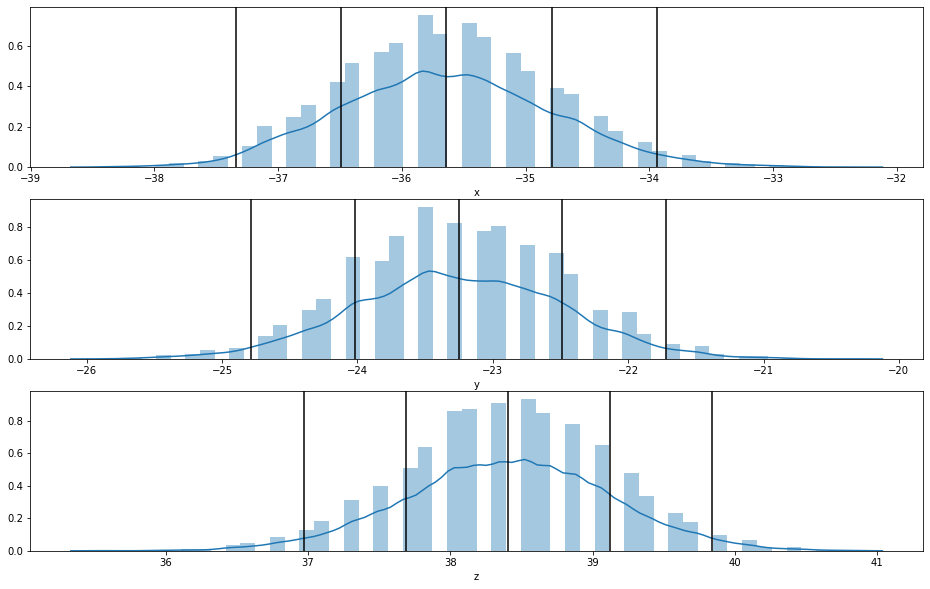

In [99]:
fig, ax = plt.subplots(3, figsize=(16,10))
for i in range(ser_data.columns.size):
    col = ser_data.columns[i]
    mean = ser_data[col].mean()
    stdev = ser_data[col].std()
    sns.distplot(ser_data[col], ax=ax[i], label='Magnetometer: {}'.format(col))
    for j in [-2, -1, 0, 1, 2]:
        ax[i].axvline(mean - (j * stdev), color='#000000')

In [114]:
data = {
    'good': pd.read_csv('./data_archive/good_readings.csv'),
    'okay': pd.read_csv('./data_archive/okay_readings.csv'),
    'bad': pd.read_csv('./data_archive/bad_readings.csv'),
    'ser': ser_data,
    'ref': pd.Series([17.8480, 4.5939, 50.8366], index=['mag_x','mag_y','mag_z'])
}

In [115]:
data_adj = {}
coefs = {}
calibs = {}
for key, val in data.items():
    if key == 'ref': continue
    calibs[key] = Calibrator(
        val.values, data['ref'],
        Model=Complex, model_params={'gradient_params':{'Learn':SqDec}},
        verbose=True
    )
    data_adj[key] = calibs[key].calibrate(5000)
    coefs[key] = calibs[key].coefs

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
coefs['good']

,bias,skew_x,skew_y,skew_z
x,24.301794,-0.346797,-1.109458,-0.435971
y,7.325425,-0.840401,0.537637,-0.529688
z,18.771332,-0.856859,-0.075513,0.932855


In [5]:
coefs['okay']

,bias,skew_x,skew_y,skew_z
x,26.467184,-0.226168,-1.197991,0.009398
y,6.171759,-1.001984,0.206929,-0.558553
z,19.954327,-0.731871,0.161964,1.064016


In [6]:
coefs['bad']

,bias,skew_x,skew_y,skew_z
x,18.134817,-0.210003,0.344305,-1.368737
y,6.025054,0.576914,1.112242,0.139604
z,14.187082,-1.200318,0.842986,0.220628


In [116]:
coefs['ser']

,bias,skew_x,skew_y,skew_z
x,1.384607,1.267201,-0.607819,0.643427
y,12.554562,-1.537303,-0.307897,1.465083
z,-1.408158,0.735935,0.815784,1.007731


In [118]:
for key, val in data_adj.items():
    print('{}:'.format(key), np.sqrt((val**2).sum(axis=1)).mean())
print('ref:', np.sqrt((data['ref']**2).sum()))

good: 53.770744
okay: 54.249943
bad: 53.87021
ser: 54.344116
ref: 54.07416130436051


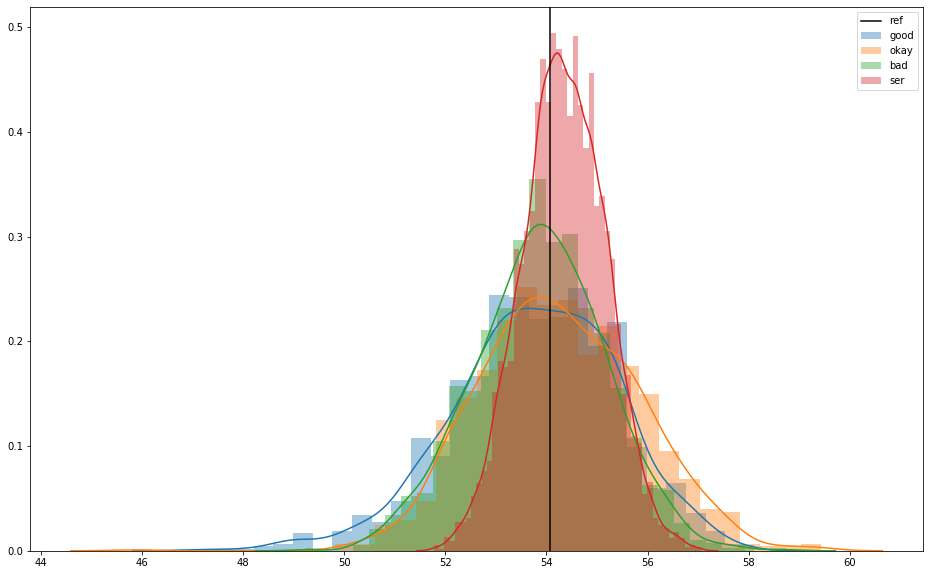

In [119]:
plt.figure(figsize=(16,10))
for key, val in data_adj.items():
    sns.distplot(np.sqrt((val**2).sum(axis=1)), label=key)
plt.axvline(np.sqrt((data['ref']**2).sum()), color='#000000', label='ref')
plt.legend()